In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import warnings
from datetime import timedelta
from pandas.tseries.offsets import MonthEnd
import statsmodels.api as sm
#import ordered dicts
from collections import OrderedDict
import scipy.stats as stats
import plotly.express as px
import plotly.graph_objects as go
from tqdm import tqdm
import pickle

In [2]:
#We have inflation factor for every company
#Pick companies with t-stat > 2 or < -2
#If inflation is going up, pick companies with beta > 0
#If inflation is going down, pick companies with beta < 0
#Sort companies by beta (How much they move with inflation)
#Create quartiles of companies based on beta

#Looking at date, and inflation prediction flip long/short based on direction of inflation

In [56]:
def get_cpi():
    cpi = pd.read_excel('data/CPIAUCSL (1).xls')
    #cpi = pd.read_csv("T5YIE.csv")
    cpi.columns = ["date", 'CPI']
    cpi["date"] = pd.to_datetime(cpi["date"]) - timedelta(days=1)
    return cpi
    

def get_stocks():
    stocks = pd.read_csv("data/comp_stocks.csv")
    stocks["datadate"] = pd.to_datetime(stocks["datadate"])
    return stocks


def merge_cpi_stock(stocks, cpi):
    merged = pd.merge(stocks, cpi, how="left", left_on="MthCalDt", right_on="date")
    return merged

def bin_inflation_regimes(cpi, labels = ["deflation","low", "mid", "high"], bins = [-10, 0,1,3,20], value = "CPI", col = "Inflation"):
    cpi[col] = pd.cut(cpi[value],bins, labels=labels)
    return cpi


def get_percent_change(cpi):
    cpi["pct_change"] = cpi["CPI"].pct_change()
    return cpi

# get difference in inflation between two months
def get_inflation_diff(cpi, col = "CPI Diff", value = "CPI"):
    cpi[col] = cpi[value].diff()
    return cpi

def get_forecast():
    forecast = pd.read_csv("data/forecast.csv")
    # string of quarters to months 
    forecast["date"] = pd.to_datetime(forecast["TIME"])
    # sort by date
    forecast = forecast.sort_values(by="date")
    # get duplicate rows in forecast
    forecast[forecast.duplicated(subset=["date"], keep=False)]
    # forecast only for USA
    forecast = forecast[forecast["LOCATION"] == "USA"]

    # remove columns that have same value for all rows
    forecast = forecast.loc[:, forecast.apply(pd.Series.nunique) != 1]

    # remove flag codes columns
    forecast = forecast.loc[:, ~forecast.columns.str.contains('^Flag Codes')]
    return forecast

In [57]:
forecast = get_forecast()

In [58]:
forecast

,TIME,Value,date
0,1961-Q1,1.508107,1961-01-01
1,1961-Q2,0.867899,1961-04-01
2,1961-Q3,1.205362,1961-07-01
3,1961-Q4,0.705171,1961-10-01
4,1962-Q1,0.893655,1962-01-01
...,...,...,...
251,2023-Q4,3.063185,2023-10-01
252,2024-Q1,2.833065,2024-01-01
253,2024-Q2,2.623820,2024-04-01
254,2024-Q3,2.475013,2024-07-01


In [14]:
cpi = get_cpi()
cpi = get_inflation_diff(cpi)

In [15]:
cpi.dropna()

,date,CPI,CPI Diff
1,1948-01-31,9.48196,-0.76013
2,1948-02-29,6.81818,-2.66378
3,1948-03-31,8.27273,1.45455
4,1948-04-30,9.38497,1.11224
5,1948-05-31,9.37500,-0.00997
...,...,...,...
895,2022-07-31,8.22736,-0.18582
896,2022-08-31,8.21485,-0.01251
897,2022-09-30,7.76249,-0.45236
898,2022-10-31,7.13535,-0.62714


In [70]:
stocks = get_stocks()
# remove stocks with above 500 trt1m
stocks = stocks[stocks["trt1m"] < 1000]

# remove stocks with below -100 trt1m
stocks = stocks[stocks["trt1m"] > -100]
# drop na gics
stocks = stocks.dropna(subset=["ggroup","gind", "gsector", "gsubind"])
# drop missing trt1m
stocks = stocks.dropna(subset=["trt1m"])

# # drop stocks that have negative price
# stocks = stocks[stocks["prccm"] > 0]

# stocks["cshoq"] = stocks.groupby("gvkey")["cshoq"].ffill()

# # drop stocks that have negative shares
# stocks = stocks[stocks["cshoq"] > 0]

# # calculate market cap
# stocks["market_cap"] = stocks["prccm"] * stocks["cshoq"]
# print(stocks.shape)

# stocks["market_cap_shifted"] = stocks.groupby("gvkey")["market_cap"].shift(1) 

/var/folders/m6/h9jtrhyn259fytxp6j9xh9v00000gn/T/ipykernel_80560/3777490750.py:10: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  stocks = pd.read_csv("data/comp_stocks.csv")


In [17]:
stocks.shape

(6394616, 22)

In [18]:
# get factors
def get_factors():

    ff_factors = pd.read_csv("data/ff_factors.csv")
    ff_factor_mom = pd.read_csv("data/ff_factor_umd.csv")
    ff_factors.rename({"Unnamed: 0": "date"}, axis=1, inplace=True)
    ff_factor_mom.rename({"Unnamed: 0": "date", "Mom":"UMD"}, axis=1, inplace=True)
    ff_factor_mom.rename({"Unnamed: 0": "date", "Mom   ":"UMD"}, axis=1, inplace=True)
    ff_factors = ff_factors.merge(ff_factor_mom, how="left", on="date")
    
    ff_factors["date"] = pd.to_datetime(ff_factors["date"], format="%Y%m")
    ff_factors["date"] += MonthEnd(0)


    return ff_factors

In [90]:
def get_company(stocks, gvkey, date):
    comp = stocks[(stocks["gvkey"] == gvkey) & (stocks["datadate"] <= date)]
    comp = comp.drop_duplicates(subset="datadate", keep="first")
    comp = comp.set_index("datadate")
    comp.index = comp.index + MonthEnd(0)

    return comp

In [104]:
def prep_reg(factors, comp_data, reg_factors = ["Mkt-RF", "SMB", "HML", "RMW", "CMA", "UMD", "CPI Diff"]):
    
    
    # add date to reg_factors
    reg_factors = ["date"] + reg_factors

    X = factors[reg_factors].set_index("date")

    comp_data["Excess Return"] = comp_data["trt1m"] - factors.set_index("date")["RF"]
    y = comp_data['Excess Return']
    

    # get indies that are the same between X and y
    indies_X = X.index.intersection(y.index)

    indies_y = y.index.intersection(X.index)

    indies = indies_X.intersection(indies_y)

    # save those rows
    X = X.loc[indies]
    y = y.loc[indies]
    
    return X, y

In [83]:
def run_reg(X, y):
    X = sm.add_constant(X)
    model = sm.OLS(y, X)
    results = model.fit()
    return results

In [22]:
ff_factors = get_factors()

In [26]:
factors = pd.merge(cpi, ff_factors, how="inner", on="date")

In [71]:
# stocks between 2005 and 2020
stocks = stocks[stocks["datadate"] > "2004-06-01"] # six months needed for regression
stocks = stocks[stocks["datadate"] < "2022-01-01"]

In [101]:
factors

,date,CPI,CPI Diff,Mkt-RF,SMB,HML,RMW,CMA,RF,UMD
0,1963-07-31,1.55218,-0.00308,-0.39,-0.41,-0.97,0.68,-1.18,0.27,0.90
1,1963-08-31,0.98619,-0.56599,5.07,-0.80,1.80,0.36,-0.35,0.25,1.01
2,1963-09-30,1.21791,0.23172,-1.57,-0.52,0.13,-0.71,0.29,0.27,0.19
3,1963-10-31,1.31666,0.09875,2.53,-1.39,-0.10,2.80,-2.01,0.29,3.12
4,1963-11-30,1.64582,0.32916,-0.85,-0.88,1.75,-0.51,2.24,0.27,-0.74
...,...,...,...,...,...,...,...,...,...,...
708,2022-07-31,8.22736,-0.18582,9.57,1.87,-4.10,0.68,-6.94,0.08,-3.96
709,2022-08-31,8.21485,-0.01251,-3.77,1.51,0.31,-4.80,1.30,0.19,2.10
710,2022-09-30,7.76249,-0.45236,-9.35,-1.00,0.03,-1.50,-0.85,0.19,3.48
711,2022-10-31,7.13535,-0.62714,7.83,1.87,8.05,3.07,6.56,0.23,3.89


In [73]:
# get dates that have the 3, 6, 9 and 12 month as dates
reconst_stock_dates = stocks[stocks["datadate"].dt.month.isin([3,6,9,12])]

In [80]:
gvkeys = reconst_stock_dates["gvkey"].unique()

In [81]:
dates_gvkeys = list(zip(reconst_stock_dates["datadate"], reconst_stock_dates["gvkey"]))

In [82]:
len(dates_gvkeys)

1035543

In [145]:
# save the betas
ff_factors = get_factors()

beta_dict = {}
t_dict = {}

for company in tqdm(dates_gvkeys):

    date = company[0]
    gvkey = company[1]

    # supress warnings
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        try:
            company_data = get_company(stocks, gvkey, date)

            if len(company_data) < 6:
                continue

            X, y = prep_reg(factors, company_data)
            
            
            if (X.shape[0] < 2) or (y.shape[0] < 2):
                continue
                    
            reg_results = run_reg(X, y)
            
            # save betas and t stats
            beta_dict[company] = reg_results.params.to_dict()
            t_dict[company] = reg_results.tvalues.to_dict()
                        

            # save dict to a file every 10000 iterations using pickle not json
            if len(beta_dict) % 10000 == 0:
                with open('beta_dict_w_factors.pickle', 'wb') as f:
                # Pickle the 'data' dictionary using the highest protocol available.
                    pickle.dump(beta_dict, f, pickle.HIGHEST_PROTOCOL)            
                    
                   
   
        except ValueError:
            print("ValueError for gvkey: ", company)
            break
    

100%|██████████| 1035543/1035543 [4:26:32<00:00, 64.75it/s]    


In [146]:
beta_df = pd.DataFrame.from_dict(beta_dict, orient="index")

In [147]:
beta_df

,,const,Mkt-RF,SMB,HML,RMW,CMA,UMD,CPI Diff
2004-12-31,1003,-0.138276,0.010059,0.026984,-0.061919,0.058570,-0.023065,-0.011800,0.047869
2005-03-31,1003,-0.128774,-0.000035,0.025105,-0.030315,0.033886,-0.007313,-0.011879,0.049594
2005-06-30,1003,-0.172917,0.015876,-0.003249,-0.014142,0.024544,-0.022686,-0.004496,0.053990
2005-09-30,1003,-4.404246,-0.161192,3.786756,-0.675228,4.244383,1.366785,-5.363642,24.304606
2005-12-31,1003,1.710249,50.739537,-37.328633,-35.158119,23.551260,-54.783362,-2.179491,90.876421
...,...,...,...,...,...,...,...,...,...
2020-06-30,351371,1.007001,-0.562695,0.472423,-2.891656,1.111710,3.695034,-0.637119,-16.713177
2020-09-30,351371,-0.076496,-0.352193,0.204517,-3.079972,1.316744,4.450750,-0.796219,-15.295812
2020-12-31,351371,0.346961,-0.484835,0.366771,-2.896275,1.409507,4.159801,-0.774811,-15.765458
2021-03-31,351371,1.383455,-0.983350,0.383224,-2.814162,1.866016,3.531918,-1.184866,-7.701344


In [148]:
t_df = pd.DataFrame.from_dict(t_dict, orient="index")

In [149]:
t_df

,,const,Mkt-RF,SMB,HML,RMW,CMA,UMD,CPI Diff
2004-12-31,1003,-0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000
2005-03-31,1003,-5.186306,-0.004412,3.084612,-1.407134,3.027088,-0.714596,-1.901116,1.137301
2005-06-30,1003,-4.505061,0.840367,-0.169640,-0.395787,0.822088,-0.818753,-0.409248,0.808658
2005-09-30,1003,-0.274062,-0.020287,0.498944,-0.051760,0.418794,0.116777,-1.328682,1.125379
2005-12-31,1003,0.015951,0.907953,-0.690888,-0.418940,0.352811,-0.714882,-0.073614,0.626448
...,...,...,...,...,...,...,...,...,...
2020-06-30,351371,0.301386,-0.517154,0.303431,-2.031784,0.403230,1.576806,-0.491899,-1.257836
2020-09-30,351371,-0.023036,-0.348261,0.132894,-2.181391,0.517083,1.983909,-0.660186,-1.143765
2020-12-31,351371,0.111898,-0.526175,0.254703,-2.206601,0.603026,2.001226,-0.694291,-1.226978
2021-03-31,351371,0.468713,-1.205338,0.280531,-2.233176,0.916113,1.987475,-1.205937,-0.772601


In [150]:
# put _t_stat at the end of the t stats
t_df.columns = [col + "_t_stat" for col in t_df.columns]

beta_t_df = pd.merge(beta_df, t_df, how="inner", left_index=True, right_index=True)


In [151]:
beta_t_df = beta_t_df.reset_index()

# rename level_0 to date and level_1 to gvkey
beta_t_df.rename({"level_0": "date", "level_1": "gvkey"}, axis=1, inplace=True)

beta_t_df

,date,gvkey,const,Mkt-RF,SMB,HML,RMW,CMA,UMD,CPI Diff,const_t_stat,Mkt-RF_t_stat,SMB_t_stat,HML_t_stat,RMW_t_stat,CMA_t_stat,UMD_t_stat,CPI Diff_t_stat
0,2004-12-31,1003,-0.138276,0.010059,0.026984,-0.061919,0.058570,-0.023065,-0.011800,0.047869,-0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000
1,2005-03-31,1003,-0.128774,-0.000035,0.025105,-0.030315,0.033886,-0.007313,-0.011879,0.049594,-5.186306,-0.004412,3.084612,-1.407134,3.027088,-0.714596,-1.901116,1.137301
2,2005-06-30,1003,-0.172917,0.015876,-0.003249,-0.014142,0.024544,-0.022686,-0.004496,0.053990,-4.505061,0.840367,-0.169640,-0.395787,0.822088,-0.818753,-0.409248,0.808658
3,2005-09-30,1003,-4.404246,-0.161192,3.786756,-0.675228,4.244383,1.366785,-5.363642,24.304606,-0.274062,-0.020287,0.498944,-0.051760,0.418794,0.116777,-1.328682,1.125379
4,2005-12-31,1003,1.710249,50.739537,-37.328633,-35.158119,23.551260,-54.783362,-2.179491,90.876421,0.015951,0.907953,-0.690888,-0.418940,0.352811,-0.714882,-0.073614,0.626448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887961,2020-06-30,351371,1.007001,-0.562695,0.472423,-2.891656,1.111710,3.695034,-0.637119,-16.713177,0.301386,-0.517154,0.303431,-2.031784,0.403230,1.576806,-0.491899,-1.257836
887962,2020-09-30,351371,-0.076496,-0.352193,0.204517,-3.079972,1.316744,4.450750,-0.796219,-15.295812,-0.023036,-0.348261,0.132894,-2.181391,0.517083,1.983909,-0.660186,-1.143765
887963,2020-12-31,351371,0.346961,-0.484835,0.366771,-2.896275,1.409507,4.159801,-0.774811,-15.765458,0.111898,-0.526175,0.254703,-2.206601,0.603026,2.001226,-0.694291,-1.226978
887964,2021-03-31,351371,1.383455,-0.983350,0.383224,-2.814162,1.866016,3.531918,-1.184866,-7.701344,0.468713,-1.205338,0.280531,-2.233176,0.916113,1.987475,-1.205937,-0.772601


# Fundamentals

In [220]:
funda = pd.read_csv("data/funda.csv")

In [217]:
''' 
Standard and Poor's Identifier (GVKEY)

Company Name (CONM)

Ticker Symbol (TIC)

CHQ -- Cash (CHQ)

DD1Q -- Long-Term Debt Due in One Year (DD1Q)

DLCQ -- Debt in Current Liabilities (DLCQ)

DLTTQ -- Long-Term Debt - Total (DLTTQ)

IVLTQ -- Total Long-term Investments (IVLTQ)

IVSTQ -- Short-Term Investments- Total (IVSTQ)

XOPRQ -- Operating Expense- Total (XOPRQ)

DLCCHY -- Changes in Current Debt (DLCCHY)

'''

" \nStandard and Poor's Identifier (GVKEY)\n\nCompany Name (CONM)\n\nTicker Symbol (TIC)\n\nCHQ -- Cash (CHQ)\n\nDD1Q -- Long-Term Debt Due in One Year (DD1Q)\n\nDLCQ -- Debt in Current Liabilities (DLCQ)\n\nDLTTQ -- Long-Term Debt - Total (DLTTQ)\n\nIVLTQ -- Total Long-term Investments (IVLTQ)\n\nIVSTQ -- Short-Term Investments- Total (IVSTQ)\n\nXOPRQ -- Operating Expense- Total (XOPRQ)\n\nDLCCHY -- Changes in Current Debt (DLCCHY)\n\n"

In [223]:
funda.rename({  "chq":"Cash", 
                "dd1q":"Long-Term Debt Due in One Year", 
                "dlcq":"Debt in Current Liabilities", 
                "dlttq":"Long-Term Debt - Total", 
                "ivltq":"Total Long-term Investments", 
                "ivstq":"Short-Term Investments- Total", 
                "xoprq":"Operating Expense- Total", 
                "dlcchy":"Changes in Current Debt", 
                "mkvaltq":"Market Value - Total",
                "atq":"Assets - Total",
                "revty" : "Revenue - Total",                
                }, axis=1, inplace=True)

In [224]:
funda.columns

Index(['GVKEY', 'datadate', 'fyearq', 'fqtr', 'indfmt', 'consol', 'popsrc',
       'datafmt', 'tic', 'conm', 'curcdq', 'datacqtr', 'datafqtr',
       'Assets - Total', 'Cash', 'Long-Term Debt Due in One Year',
       'Debt in Current Liabilities', 'Long-Term Debt - Total',
       'Total Long-term Investments', 'Short-Term Investments- Total',
       'Operating Expense- Total', 'Changes in Current Debt',
       'Revenue - Total', 'costat', 'Market Value - Total'],
      dtype='object')

In [225]:
# add 3 months to datadate and call that report date
funda["datadate"] = pd.to_datetime(funda["datadate"])
funda["report date"] = funda["datadate"] + MonthEnd(3)


In [226]:
funda["Long-Term Debt Due in One Year Percent"] = funda["Long-Term Debt Due in One Year"] / funda["Long-Term Debt - Total"]

funda["Long-Term Debt Percent"] = funda["Long-Term Debt - Total"] / (funda["Debt in Current Liabilities"] + funda["Long-Term Debt - Total"])
funda["Short-Term Debt Percent"] = funda["Debt in Current Liabilities"] / (funda["Debt in Current Liabilities"] + funda["Long-Term Debt - Total"])

funda["Cash Percent"] = funda["Cash"] / (funda["Cash"] + funda["Short-Term Investments- Total"] + funda["Total Long-term Investments"])

funda["Total Long-term Investments Percent"] = funda["Total Long-term Investments"] / (funda["Short-Term Investments- Total"] + funda["Total Long-term Investments"])
funda["Total Short-term Investments Percent"] = funda["Short-Term Investments- Total"] / (funda["Short-Term Investments- Total"] + funda["Total Long-term Investments"])

funda["Operating Expense Ratio"] = funda["Operating Expense- Total"] / funda["Revenue - Total"]

In [227]:
funda.isna().sum()

GVKEY                                           0
datadate                                        0
fyearq                                          0
fqtr                                            0
indfmt                                          0
consol                                          0
popsrc                                          0
datafmt                                         0
tic                                             1
conm                                            0
curcdq                                          0
datacqtr                                     1653
datafqtr                                        0
Assets - Total                             186220
Cash                                       905940
Long-Term Debt Due in One Year            1042002
Debt in Current Liabilities                231829
Long-Term Debt - Total                     169929
Total Long-term Investments                864789
Short-Term Investments- Total              919081


In [230]:
keep = ["GVKEY", "report date", "Long-Term Debt Due in One Year Percent", "Long-Term Debt Percent", "Short-Term Debt Percent", "Cash Percent", "Total Long-term Investments Percent", "Total Short-term Investments Percent", "Operating Expense Ratio"]

In [231]:
funda = funda[keep]

In [232]:
beta_t_df

,date,gvkey,const,Mkt-RF,SMB,HML,RMW,CMA,UMD,CPI Diff,const_t_stat,Mkt-RF_t_stat,SMB_t_stat,HML_t_stat,RMW_t_stat,CMA_t_stat,UMD_t_stat,CPI Diff_t_stat
0,2004-12-31,1003,-0.138276,0.010059,0.026984,-0.061919,0.058570,-0.023065,-0.011800,0.047869,-0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000
1,2005-03-31,1003,-0.128774,-0.000035,0.025105,-0.030315,0.033886,-0.007313,-0.011879,0.049594,-5.186306,-0.004412,3.084612,-1.407134,3.027088,-0.714596,-1.901116,1.137301
2,2005-06-30,1003,-0.172917,0.015876,-0.003249,-0.014142,0.024544,-0.022686,-0.004496,0.053990,-4.505061,0.840367,-0.169640,-0.395787,0.822088,-0.818753,-0.409248,0.808658
3,2005-09-30,1003,-4.404246,-0.161192,3.786756,-0.675228,4.244383,1.366785,-5.363642,24.304606,-0.274062,-0.020287,0.498944,-0.051760,0.418794,0.116777,-1.328682,1.125379
4,2005-12-31,1003,1.710249,50.739537,-37.328633,-35.158119,23.551260,-54.783362,-2.179491,90.876421,0.015951,0.907953,-0.690888,-0.418940,0.352811,-0.714882,-0.073614,0.626448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887961,2020-06-30,351371,1.007001,-0.562695,0.472423,-2.891656,1.111710,3.695034,-0.637119,-16.713177,0.301386,-0.517154,0.303431,-2.031784,0.403230,1.576806,-0.491899,-1.257836
887962,2020-09-30,351371,-0.076496,-0.352193,0.204517,-3.079972,1.316744,4.450750,-0.796219,-15.295812,-0.023036,-0.348261,0.132894,-2.181391,0.517083,1.983909,-0.660186,-1.143765
887963,2020-12-31,351371,0.346961,-0.484835,0.366771,-2.896275,1.409507,4.159801,-0.774811,-15.765458,0.111898,-0.526175,0.254703,-2.206601,0.603026,2.001226,-0.694291,-1.226978
887964,2021-03-31,351371,1.383455,-0.983350,0.383224,-2.814162,1.866016,3.531918,-1.184866,-7.701344,0.468713,-1.205338,0.280531,-2.233176,0.916113,1.987475,-1.205937,-0.772601


In [233]:
# merge beta_t_df with funda on gvkey and report date
beta_t_funda = pd.merge(beta_t_df, funda, how="inner", left_on=["date", "gvkey"], right_on=["report date", "GVKEY"])

In [234]:
# find sigificant betas for cpi diff
beta_t_funda[abs(beta_t_funda["CPI Diff_t_stat"]) > 3]

,date,gvkey,const,Mkt-RF,SMB,HML,RMW,CMA,UMD,CPI Diff,...,CPI Diff_t_stat,GVKEY,report date,Long-Term Debt Due in One Year Percent,Long-Term Debt Percent,Short-Term Debt Percent,Cash Percent,Total Long-term Investments Percent,Total Short-term Investments Percent,Operating Expense Ratio
227,2005-03-31,1075,-4.877035,1.659626,0.846775,5.324797,-0.607216,-0.690056,-2.170726,11.229796,...,4.097631,1075,2005-03-31,NaN,0.789747,0.210253,NaN,NaN,NaN,0.181979
765,2005-03-31,1161,-14.176924,8.591560,5.612353,10.185375,3.366672,2.989373,-5.962305,53.887539,...,3.012727,1161,2005-03-31,NaN,0.875839,0.124161,NaN,NaN,NaN,0.182326
883,2005-03-31,1177,-10.514585,5.140738,-2.450534,13.354668,-4.502885,-4.748124,0.077585,3.740382,...,3.242902,1177,2005-03-31,NaN,1.000000,0.000000,NaN,NaN,NaN,0.230319
939,2005-03-31,1186,-16.754353,6.151968,-0.628416,11.314410,1.681008,-1.241984,-2.786355,41.032344,...,4.309442,1186,2005-03-31,NaN,1.000000,0.000000,NaN,NaN,NaN,0.134375
940,2005-06-30,1186,-6.106419,3.768420,-2.653889,2.721909,1.663432,-0.333178,0.144453,19.543607,...,3.128059,1186,2005-06-30,NaN,1.000000,0.000000,NaN,NaN,NaN,0.620600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318198,2021-09-30,325867,-13.903822,1.408790,4.816038,-3.840893,-0.644892,-4.279749,1.979693,26.251782,...,3.574284,325867,2021-09-30,1.592120,0.385785,0.614215,0.983808,1.00000,0.00000,31.953743
318226,2021-06-30,327451,-1.190008,0.399515,0.100292,0.341832,-2.353779,0.350497,0.529072,23.514010,...,3.089160,327451,2021-06-30,NaN,NaN,NaN,NaN,NaN,NaN,0.695506
318235,2019-09-30,328032,-6.223484,1.561390,-8.194390,3.658133,-8.776432,-1.763235,-0.203901,29.589727,...,420.734056,328032,2019-09-30,0.243789,0.803995,0.196005,0.605030,0.82828,0.17172,0.325859
318260,2019-12-31,330227,-11.036212,-5.695396,6.019047,5.048371,26.685688,-17.511926,3.153702,119.517747,...,4.180521,330227,2019-12-31,0.000000,1.000000,0.000000,1.000000,NaN,NaN,0.248241


In [236]:
beta_t_funda.isna().sum()

date                                           0
gvkey                                          0
const                                          0
Mkt-RF                                         0
SMB                                            0
HML                                            0
RMW                                            0
CMA                                            0
UMD                                            0
CPI Diff                                       0
const_t_stat                                   0
Mkt-RF_t_stat                                  0
SMB_t_stat                                     0
HML_t_stat                                     0
RMW_t_stat                                     0
CMA_t_stat                                     0
UMD_t_stat                                     0
CPI Diff_t_stat                                0
GVKEY                                          0
report date                                    0
Long-Term Debt Due i

In [247]:
temp = beta_t_funda.dropna()

In [248]:
temp = temp[abs(temp["CPI Diff_t_stat"]) > 2]

<AxesSubplot:>

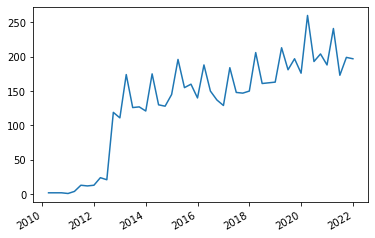

In [249]:
# plot count of significant t stats postive and negative by date
temp["date"].value_counts().plot()

# Macros

In [276]:
# read in GDP
gdp = pd.read_csv("data/GDP.csv")

unemployment = pd.read_excel("data/UNRATE.xls")

corp_profits = pd.read_excel("data/CP.xls")

# read in FEDFUND
fedfund = pd.read_csv("data/FEDFUNDS.csv")

In [277]:
# add 3 months to date and call that report date
unemployment["observation_date"] = pd.to_datetime(unemployment["observation_date"])

unemployment["report date"] = unemployment["observation_date"] + MonthEnd(3)

# drop observation date
unemployment.drop("observation_date", axis=1, inplace=True)

In [278]:
corp_profits["observation_date"] = pd.to_datetime(corp_profits["observation_date"])

corp_profits["report date"] = corp_profits["observation_date"] + MonthEnd(3)
corp_profits.drop("observation_date", axis=1, inplace=True)

In [279]:
gdp["DATE"] = pd.to_datetime(gdp["DATE"])
gdp["report date"] = gdp["DATE"] + MonthEnd(3)
gdp.drop("DATE", axis=1, inplace=True)

In [280]:
# report date is the end of the month 
fedfund["DATE"] = pd.to_datetime(fedfund["DATE"])
fedfund["report date"] = fedfund["DATE"] + MonthEnd(0)
fedfund.drop("DATE", axis=1, inplace=True)

In [283]:
# merge corp_profits with unemployment with gdp with fedfund on report date
macros = pd.merge(corp_profits, unemployment, how="inner", left_on="report date", right_on="report date")
macros = pd.merge(macros, gdp, how="inner", left_on="report date", right_on="report date")
macros = pd.merge(macros, fedfund, how="inner", left_on="report date", right_on="report date")

In [284]:
macros

,CP,report date,UNRATE,GDP,FEDFUNDS
0,23.813,1954-09-30,5.966667,390.996,1.07
1,25.515,1954-12-31,5.333333,399.734,1.28
2,28.583,1955-03-31,4.733333,413.073,1.35
3,29.064,1955-06-30,4.400000,421.532,1.64
4,29.843,1955-09-30,4.100000,430.221,2.18
...,...,...,...,...,...
268,2827.118,2021-09-30,5.133333,23550.420,0.08
269,2760.777,2021-12-31,4.200000,24349.121,0.08
270,2833.431,2022-03-31,3.800000,24740.480,0.20
271,3043.114,2022-06-30,3.600000,25248.476,1.21


In [285]:
beta_t_df

,date,gvkey,const,Mkt-RF,SMB,HML,RMW,CMA,UMD,CPI Diff,const_t_stat,Mkt-RF_t_stat,SMB_t_stat,HML_t_stat,RMW_t_stat,CMA_t_stat,UMD_t_stat,CPI Diff_t_stat
0,2004-12-31,1003,-0.138276,0.010059,0.026984,-0.061919,0.058570,-0.023065,-0.011800,0.047869,-0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000
1,2005-03-31,1003,-0.128774,-0.000035,0.025105,-0.030315,0.033886,-0.007313,-0.011879,0.049594,-5.186306,-0.004412,3.084612,-1.407134,3.027088,-0.714596,-1.901116,1.137301
2,2005-06-30,1003,-0.172917,0.015876,-0.003249,-0.014142,0.024544,-0.022686,-0.004496,0.053990,-4.505061,0.840367,-0.169640,-0.395787,0.822088,-0.818753,-0.409248,0.808658
3,2005-09-30,1003,-4.404246,-0.161192,3.786756,-0.675228,4.244383,1.366785,-5.363642,24.304606,-0.274062,-0.020287,0.498944,-0.051760,0.418794,0.116777,-1.328682,1.125379
4,2005-12-31,1003,1.710249,50.739537,-37.328633,-35.158119,23.551260,-54.783362,-2.179491,90.876421,0.015951,0.907953,-0.690888,-0.418940,0.352811,-0.714882,-0.073614,0.626448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887961,2020-06-30,351371,1.007001,-0.562695,0.472423,-2.891656,1.111710,3.695034,-0.637119,-16.713177,0.301386,-0.517154,0.303431,-2.031784,0.403230,1.576806,-0.491899,-1.257836
887962,2020-09-30,351371,-0.076496,-0.352193,0.204517,-3.079972,1.316744,4.450750,-0.796219,-15.295812,-0.023036,-0.348261,0.132894,-2.181391,0.517083,1.983909,-0.660186,-1.143765
887963,2020-12-31,351371,0.346961,-0.484835,0.366771,-2.896275,1.409507,4.159801,-0.774811,-15.765458,0.111898,-0.526175,0.254703,-2.206601,0.603026,2.001226,-0.694291,-1.226978
887964,2021-03-31,351371,1.383455,-0.983350,0.383224,-2.814162,1.866016,3.531918,-1.184866,-7.701344,0.468713,-1.205338,0.280531,-2.233176,0.916113,1.987475,-1.205937,-0.772601


In [290]:
stocks

,gvkey,iid,datadate,tic,cusip,conm,dvrate,cshtrm,prccm,trfm,...,cshom,exchg,cik,ggroup,gind,gsector,gsubind,sic,spcindcd,spcseccd
358,1003,01,2004-06-30,ANTQ,000354100,A.A. IMPORTING CO INC,NaN,NaN,0.04,1.0,...,2683000.0,19.0,730052.0,2550.0,255040.0,25.0,25504040.0,5712.0,449.0,976.0
359,1003,01,2004-07-31,ANTQ,000354100,A.A. IMPORTING CO INC,NaN,NaN,0.04,1.0,...,2683000.0,19.0,730052.0,2550.0,255040.0,25.0,25504040.0,5712.0,449.0,976.0
360,1003,01,2004-08-31,ANTQ,000354100,A.A. IMPORTING CO INC,NaN,NaN,0.04,1.0,...,2683000.0,19.0,730052.0,2550.0,255040.0,25.0,25504040.0,5712.0,449.0,976.0
361,1003,01,2004-09-30,ANTQ,000354100,A.A. IMPORTING CO INC,NaN,NaN,0.04,1.0,...,2683000.0,19.0,730052.0,2550.0,255040.0,25.0,25504040.0,5712.0,449.0,976.0
362,1003,01,2004-10-31,ANTQ,000354100,A.A. IMPORTING CO INC,NaN,NaN,0.04,1.0,...,2683000.0,19.0,730052.0,2550.0,255040.0,25.0,25504040.0,5712.0,449.0,976.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7677700,351371,01C,2021-08-31,ODD.,67578E100,ODD BURGER CORP,NaN,807068.0,1.03,1.0,...,43904000.0,9.0,1949766.0,2530.0,253010.0,25.0,25301040.0,5812.0,NaN,NaN
7677701,351371,01C,2021-09-30,ODD.,67578E100,ODD BURGER CORP,NaN,469383.0,0.90,1.0,...,82779000.0,9.0,1949766.0,2530.0,253010.0,25.0,25301040.0,5812.0,NaN,NaN
7677702,351371,01C,2021-10-31,ODD.,67578E100,ODD BURGER CORP,NaN,230899.0,0.93,1.0,...,82779000.0,9.0,1949766.0,2530.0,253010.0,25.0,25301040.0,5812.0,NaN,NaN
7677703,351371,01C,2021-11-30,ODD.,67578E100,ODD BURGER CORP,NaN,933891.0,0.57,1.0,...,82779000.0,9.0,1949766.0,2530.0,253010.0,25.0,25301040.0,5812.0,NaN,NaN


In [295]:
beta_t_price = pd.merge(beta_t_df, stocks[["gvkey", "datadate", "prccm"]], how="left", left_on=["gvkey", "date"], right_on=["gvkey", "datadate"])

In [301]:
# shift price back groupby gvkey
beta_t_price["next prccm"] = beta_t_price.groupby("gvkey")["prccm"].shift(1)

In [302]:
# drop na in next prccm
beta_t_price = beta_t_price.dropna()

In [304]:
# drop datadate
beta_t_price.drop("datadate", axis=1, inplace=True)

/var/folders/m6/h9jtrhyn259fytxp6j9xh9v00000gn/T/ipykernel_80560/432146452.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [305]:
beta_t_price

,date,gvkey,const,Mkt-RF,SMB,HML,RMW,CMA,UMD,CPI Diff,const_t_stat,Mkt-RF_t_stat,SMB_t_stat,HML_t_stat,RMW_t_stat,CMA_t_stat,UMD_t_stat,CPI Diff_t_stat,prccm,next prccm
1,2005-03-31,1003,-0.128774,-0.000035,0.025105,-0.030315,0.033886,-0.007313,-0.011879,0.049594,-5.186306,-0.004412,3.084612,-1.407134,3.027088,-0.714596,-1.901116,1.137301,0.040,0.040
2,2005-06-30,1003,-0.172917,0.015876,-0.003249,-0.014142,0.024544,-0.022686,-0.004496,0.053990,-4.505061,0.840367,-0.169640,-0.395787,0.822088,-0.818753,-0.409248,0.808658,0.040,0.040
3,2005-09-30,1003,-4.404246,-0.161192,3.786756,-0.675228,4.244383,1.366785,-5.363642,24.304606,-0.274062,-0.020287,0.498944,-0.051760,0.418794,0.116777,-1.328682,1.125379,0.001,0.040
4,2005-12-31,1003,1.710249,50.739537,-37.328633,-35.158119,23.551260,-54.783362,-2.179491,90.876421,0.015951,0.907953,-0.690888,-0.418940,0.352811,-0.714882,-0.073614,0.626448,0.350,0.001
5,2006-03-31,1003,21.065379,40.909397,-26.008365,-44.697992,25.587204,-48.377747,-3.801966,80.330236,0.321860,1.093956,-0.797480,-0.693875,0.457281,-0.872084,-0.148382,0.722303,0.030,0.350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
985582,2020-06-30,351371,1.007001,-0.562695,0.472423,-2.891656,1.111710,3.695034,-0.637119,-16.713177,0.301386,-0.517154,0.303431,-2.031784,0.403230,1.576806,-0.491899,-1.257836,0.095,0.095
985583,2020-09-30,351371,-0.076496,-0.352193,0.204517,-3.079972,1.316744,4.450750,-0.796219,-15.295812,-0.023036,-0.348261,0.132894,-2.181391,0.517083,1.983909,-0.660186,-1.143765,0.055,0.095
985584,2020-12-31,351371,0.346961,-0.484835,0.366771,-2.896275,1.409507,4.159801,-0.774811,-15.765458,0.111898,-0.526175,0.254703,-2.206601,0.603026,2.001226,-0.694291,-1.226978,0.055,0.055
985585,2021-03-31,351371,1.383455,-0.983350,0.383224,-2.814162,1.866016,3.531918,-1.184866,-7.701344,0.468713,-1.205338,0.280531,-2.233176,0.916113,1.987475,-1.205937,-0.772601,0.055,0.055


In [317]:
# merge beta_t_price with macros on report date
beta_t_price_macros = pd.merge(beta_t_price, macros, how="inner", left_on="date", right_on="report date")

In [318]:
beta_t_price_macros

,date,gvkey,const,Mkt-RF,SMB,HML,RMW,CMA,UMD,CPI Diff,...,CMA_t_stat,UMD_t_stat,CPI Diff_t_stat,prccm,next prccm,CP,report date,UNRATE,GDP,FEDFUNDS
0,2005-03-31,1003,-0.128774,-0.000035,0.025105,-0.030315,0.033886,-0.007313,-0.011879,0.049594,...,-0.714596,-1.901116,1.137301,0.04,0.040,1228.657,2005-03-31,5.300000,12767.286,2.63
1,2005-03-31,1004,0.721737,-3.261517,5.726404,10.231179,-7.571965,1.297026,-1.548879,-2.338341,...,0.184114,-0.360099,-0.077898,13.60,13.620,1228.657,2005-03-31,5.300000,12767.286,2.63
2,2005-03-31,1013,16.719567,-1.673071,6.454995,-18.550517,10.437823,10.332925,-0.964580,-7.275049,...,1.755372,-0.268380,-0.290043,1.99,2.680,1228.657,2005-03-31,5.300000,12767.286,2.63
3,2005-03-31,1019,0.202188,0.155977,0.280230,1.016503,-0.276007,-0.725512,0.007871,-0.065477,...,-1.014043,0.018017,-0.021478,336.00,322.000,1228.657,2005-03-31,5.300000,12767.286,2.63
4,2005-03-31,1021,-1.699816,7.723289,-4.591634,-11.856072,16.501051,7.725220,4.177618,7.676217,...,1.115248,0.987769,0.260069,1.49,1.280,1228.657,2005-03-31,5.300000,12767.286,2.63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
950966,2004-12-31,266263,0.457662,1.606903,-1.654449,-1.073372,-0.124326,-1.944701,0.616727,-10.814450,...,-0.000000,0.000000,-0.000000,10.90,61.760,1010.647,2004-12-31,5.433333,12527.214,2.16
950967,2004-12-31,266304,69.801204,-31.962492,-21.360342,34.329732,-49.959611,41.804625,25.844546,-54.309454,...,0.000000,0.000000,-0.000000,0.26,0.115,1010.647,2004-12-31,5.433333,12527.214,2.16
950968,2004-12-31,266305,4.884429,-2.069733,0.698436,2.600555,-3.887468,0.849362,1.294839,11.553286,...,0.000000,0.000000,0.000000,5.65,14.990,1010.647,2004-12-31,5.433333,12527.214,2.16
950969,2004-12-31,270989,-0.177299,1.508578,0.385526,-4.079815,2.039313,-2.618828,-0.619923,-3.651183,...,-0.000000,-0.000000,-0.000000,6.95,5.250,1010.647,2004-12-31,5.433333,12527.214,2.16


In [319]:
# target is if next price is greater than current price as one
beta_t_price_macros["target"] = beta_t_price_macros["next prccm"] > beta_t_price_macros["prccm"]

# true false to one and zero
beta_t_price_macros["target"] = beta_t_price_macros["target"].astype(int)

In [320]:
beta_t_price_macros

,date,gvkey,const,Mkt-RF,SMB,HML,RMW,CMA,UMD,CPI Diff,...,UMD_t_stat,CPI Diff_t_stat,prccm,next prccm,CP,report date,UNRATE,GDP,FEDFUNDS,target
0,2005-03-31,1003,-0.128774,-0.000035,0.025105,-0.030315,0.033886,-0.007313,-0.011879,0.049594,...,-1.901116,1.137301,0.04,0.040,1228.657,2005-03-31,5.300000,12767.286,2.63,0
1,2005-03-31,1004,0.721737,-3.261517,5.726404,10.231179,-7.571965,1.297026,-1.548879,-2.338341,...,-0.360099,-0.077898,13.60,13.620,1228.657,2005-03-31,5.300000,12767.286,2.63,1
2,2005-03-31,1013,16.719567,-1.673071,6.454995,-18.550517,10.437823,10.332925,-0.964580,-7.275049,...,-0.268380,-0.290043,1.99,2.680,1228.657,2005-03-31,5.300000,12767.286,2.63,1
3,2005-03-31,1019,0.202188,0.155977,0.280230,1.016503,-0.276007,-0.725512,0.007871,-0.065477,...,0.018017,-0.021478,336.00,322.000,1228.657,2005-03-31,5.300000,12767.286,2.63,0
4,2005-03-31,1021,-1.699816,7.723289,-4.591634,-11.856072,16.501051,7.725220,4.177618,7.676217,...,0.987769,0.260069,1.49,1.280,1228.657,2005-03-31,5.300000,12767.286,2.63,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
950966,2004-12-31,266263,0.457662,1.606903,-1.654449,-1.073372,-0.124326,-1.944701,0.616727,-10.814450,...,0.000000,-0.000000,10.90,61.760,1010.647,2004-12-31,5.433333,12527.214,2.16,1
950967,2004-12-31,266304,69.801204,-31.962492,-21.360342,34.329732,-49.959611,41.804625,25.844546,-54.309454,...,0.000000,-0.000000,0.26,0.115,1010.647,2004-12-31,5.433333,12527.214,2.16,0
950968,2004-12-31,266305,4.884429,-2.069733,0.698436,2.600555,-3.887468,0.849362,1.294839,11.553286,...,0.000000,0.000000,5.65,14.990,1010.647,2004-12-31,5.433333,12527.214,2.16,1
950969,2004-12-31,270989,-0.177299,1.508578,0.385526,-4.079815,2.039313,-2.618828,-0.619923,-3.651183,...,-0.000000,-0.000000,6.95,5.250,1010.647,2004-12-31,5.433333,12527.214,2.16,0


In [321]:
# get value counts of target
beta_t_price_macros["target"].value_counts()

0    503627
1    447344
Name: target, dtype: int64

In [322]:
beta_t_price_macros.columns

Index(['date', 'gvkey', 'const', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'UMD',
       'CPI Diff', 'const_t_stat', 'Mkt-RF_t_stat', 'SMB_t_stat', 'HML_t_stat',
       'RMW_t_stat', 'CMA_t_stat', 'UMD_t_stat', 'CPI Diff_t_stat', 'prccm',
       'next prccm', 'CP', 'report date', 'UNRATE', 'GDP', 'FEDFUNDS',
       'target'],
      dtype='object')

In [323]:
# drop any columns 
beta_t_price_macros.drop(["gvkey","prccm", "next prccm", "const", "report date", "const_t_stat"], axis=1, inplace=True)

In [324]:
beta_t_price_macros


,date,Mkt-RF,SMB,HML,RMW,CMA,UMD,CPI Diff,Mkt-RF_t_stat,SMB_t_stat,HML_t_stat,RMW_t_stat,CMA_t_stat,UMD_t_stat,CPI Diff_t_stat,CP,UNRATE,GDP,FEDFUNDS,target
0,2005-03-31,-0.000035,0.025105,-0.030315,0.033886,-0.007313,-0.011879,0.049594,-0.004412,3.084612,-1.407134,3.027088,-0.714596,-1.901116,1.137301,1228.657,5.300000,12767.286,2.63,0
1,2005-03-31,-3.261517,5.726404,10.231179,-7.571965,1.297026,-1.548879,-2.338341,-0.601345,1.022093,0.689883,-0.982619,0.184114,-0.360099,-0.077898,1228.657,5.300000,12767.286,2.63,1
2,2005-03-31,-1.673071,6.454995,-18.550517,10.437823,10.332925,-0.964580,-7.275049,-0.369170,1.378834,-1.496971,1.621042,1.755372,-0.268380,-0.290043,1228.657,5.300000,12767.286,2.63,1
3,2005-03-31,0.155977,0.280230,1.016503,-0.276007,-0.725512,0.007871,-0.065477,0.283164,0.492490,0.674888,-0.352672,-1.014043,0.018017,-0.021478,1228.657,5.300000,12767.286,2.63,0
4,2005-03-31,7.723289,-4.591634,-11.856072,16.501051,7.725220,4.177618,7.676217,1.448201,-0.833485,-0.813042,2.177763,1.115248,0.987769,0.260069,1228.657,5.300000,12767.286,2.63,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
950966,2004-12-31,1.606903,-1.654449,-1.073372,-0.124326,-1.944701,0.616727,-10.814450,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,1010.647,5.433333,12527.214,2.16,1
950967,2004-12-31,-31.962492,-21.360342,34.329732,-49.959611,41.804625,25.844546,-54.309454,-0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,1010.647,5.433333,12527.214,2.16,0
950968,2004-12-31,-2.069733,0.698436,2.600555,-3.887468,0.849362,1.294839,11.553286,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,1010.647,5.433333,12527.214,2.16,1
950969,2004-12-31,1.508578,0.385526,-4.079815,2.039313,-2.618828,-0.619923,-3.651183,0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,1010.647,5.433333,12527.214,2.16,0


In [331]:
# date minus one
forecast["date"] = forecast["date"] - MonthEnd(1)

In [333]:
# prediction date is 3 months ago
forecast["prediction date"] = forecast["date"] - MonthEnd(3)

In [337]:
forecast.rename({"Value": "Forecast Inflation"}, axis=1, inplace=True)

In [338]:
forecast

,TIME,Forecast Inflation,date,prediction date
0,1961-Q1,1.508107,1960-12-31,1960-09-30
1,1961-Q2,0.867899,1961-03-31,1960-12-31
2,1961-Q3,1.205362,1961-06-30,1961-03-31
3,1961-Q4,0.705171,1961-09-30,1961-06-30
4,1962-Q1,0.893655,1961-12-31,1961-09-30
...,...,...,...,...
251,2023-Q4,3.063185,2023-09-30,2023-06-30
252,2024-Q1,2.833065,2023-12-31,2023-09-30
253,2024-Q2,2.623820,2024-03-31,2023-12-31
254,2024-Q3,2.475013,2024-06-30,2024-03-31


In [340]:
# merge forecast with beta_t_price_macros on date
beta_t_price_macros_forecast = pd.merge(forecast[["Forecast Inflation", "prediction date"]], beta_t_price_macros, how="inner", left_on="prediction date", right_on="date")

In [351]:
cpi

,date,CPI,CPI Diff
0,1947-12-31,10.24209,NaN
1,1948-01-31,9.48196,-0.76013
2,1948-02-29,6.81818,-2.66378
3,1948-03-31,8.27273,1.45455
4,1948-04-30,9.38497,1.11224
...,...,...,...
895,2022-07-31,8.22736,-0.18582
896,2022-08-31,8.21485,-0.01251
897,2022-09-30,7.76249,-0.45236
898,2022-10-31,7.13535,-0.62714


In [ ]:
beta_t_price_macros_forecast = pd.merge(forecast[["Forecast Inflation", "prediction date"]], beta_t_price_macros, how="inner", left_on="prediction date", right_on="date")

In [341]:
# drop prediction date
beta_t_price_macros_forecast.drop("prediction date", axis=1, inplace=True)

In [352]:
# merge with cpi on date
beta_t_price_macros_forecast_cpi = pd.merge(beta_t_price_macros_forecast, cpi[["date", "CPI"]], how="inner", left_on="date", right_on="date")

In [354]:
beta_t_price_macros_forecast_cpi["Predicted Next CPI Diff"] = beta_t_price_macros_forecast_cpi["Forecast Inflation"] - beta_t_price_macros_forecast_cpi["CPI"]

In [356]:
# drop forecast inflation and cpi
beta_t_price_macros_forecast_cpi.drop(["Forecast Inflation", "CPI"], axis=1, inplace=True)

In [357]:
# train test split on date
train = beta_t_price_macros_forecast_cpi[beta_t_price_macros_forecast_cpi["date"] < "2018-01-01"]
test = beta_t_price_macros_forecast_cpi[beta_t_price_macros_forecast_cpi["date"] >= "2018-01-01"]

In [358]:
# drop date
train.drop("date", axis=1, inplace=True)
test.drop("date", axis=1, inplace=True)

/var/folders/m6/h9jtrhyn259fytxp6j9xh9v00000gn/T/ipykernel_80560/3598176358.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/m6/h9jtrhyn259fytxp6j9xh9v00000gn/T/ipykernel_80560/3598176358.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [363]:
X_train = train.drop("target", axis=1)
X_test = test.drop("target", axis=1)

y_train = train["target"]
y_test = test["target"]


In [364]:
X_train

,Mkt-RF,SMB,HML,RMW,CMA,UMD,CPI Diff,Mkt-RF_t_stat,SMB_t_stat,HML_t_stat,RMW_t_stat,CMA_t_stat,UMD_t_stat,CPI Diff_t_stat,CP,UNRATE,GDP,FEDFUNDS,Predicted Next CPI Diff
0,-1.926694,3.139536,-6.635232,3.708540,4.114595,1.539939,-9.513541,-0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,1010.647,5.433333,12527.214,2.16,0.078071
1,-5.389968,-7.632829,15.671825,-15.621369,11.329795,7.153614,-19.165295,-0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,1010.647,5.433333,12527.214,2.16,0.078071
2,2.590749,1.479024,-0.587178,2.187723,-3.630193,-1.416851,7.127115,0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,1010.647,5.433333,12527.214,2.16,0.078071
3,-11.295197,5.996558,-18.231506,0.884764,15.483108,-1.971293,-1.550684,-0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,1010.647,5.433333,12527.214,2.16,0.078071
4,6.004312,-2.615900,12.782955,-3.493451,-5.250629,0.019998,5.226545,0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,1010.647,5.433333,12527.214,2.16,0.078071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
742132,0.356980,3.092662,-8.654602,-0.067372,8.505668,1.169472,-4.798417,0.105574,1.660033,-2.803574,-0.047112,3.206547,0.531598,-0.256253,1779.136,4.166667,19894.750,1.30,0.536293
742133,9.027255,-1.252299,-0.390821,1.737895,-1.692733,-3.097279,0.356748,0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,1779.136,4.166667,19894.750,1.30,0.536293
742134,-5.266977,11.009658,0.521269,4.967657,-12.536572,0.065047,18.064914,-1.324366,1.782772,0.081926,0.564007,-1.185448,0.021801,0.623734,1779.136,4.166667,19894.750,1.30,0.536293
742135,-3.073957,-0.091338,-0.781209,-5.751924,-4.834263,-2.784668,-9.427790,-1.826614,-0.036357,-0.245197,-1.550925,-1.052583,-1.593810,-0.547652,1779.136,4.166667,19894.750,1.30,0.536293


In [365]:
# import decision tree classifier
from sklearn.tree import DecisionTreeClassifier

In [366]:
# fit decision tree classifier
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [367]:
# predict on test
y_pred = dt.predict(X_test)

In [368]:
# import accuracy score
from sklearn.metrics import accuracy_score

# accuracy score
accuracy_score(y_test, y_pred)

0.5195466255494795

In [369]:
# import confusion matrix
from sklearn.metrics import confusion_matrix

# confusion matrix
confusion_matrix(y_test, y_pred)

array([[74091, 39790],
       [60545, 34408]])

In [370]:
# import classification report
from sklearn.metrics import classification_report

# classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.55      0.65      0.60    113881
           1       0.46      0.36      0.41     94953

    accuracy                           0.52    208834
   macro avg       0.51      0.51      0.50    208834
weighted avg       0.51      0.52      0.51    208834



In [375]:
# get feature importance readable
feature_importance = pd.DataFrame({"feature": X_train.columns, "importance": dt.feature_importances_})
feature_importance.sort_values("importance", ascending=False)

,feature,importance
7,Mkt-RF_t_stat,0.079142
9,HML_t_stat,0.069155
10,RMW_t_stat,0.067344
12,UMD_t_stat,0.067132
8,SMB_t_stat,0.067121
13,CPI Diff_t_stat,0.066411
11,CMA_t_stat,0.066077
2,HML,0.064885
0,Mkt-RF,0.063117
6,CPI Diff,0.062196


In [378]:
beta_t_price_macros_forecast_cpi["target"].value_counts()

0    503627
1    447344
Name: target, dtype: int64

In [379]:
# get value counts of y test and y train as percentages
print(y_test.value_counts(normalize=True))
print(y_train.value_counts(normalize=True))

0    0.545318
1    0.454682
Name: target, dtype: float64
0    0.525167
1    0.474833
Name: target, dtype: float64


In [171]:
# read in FEDFUND
fedfund = pd.read_csv("data/FEDFUNDS.csv")

# read in GDPNOW.csv
gdpnow = pd.read_csv("data/GDPNOW.csv")

# read in macroecomonic_Data.xlsx
macro = pd.read_excel("data/macroeconomic_Data.xlsx")

In [173]:
# substract date by one day
fedfund["DATE"] = pd.to_datetime(fedfund["DATE"]) - pd.Timedelta(days=1)

In [178]:
macro

,Date,Total Assets
0,2007-08-01,870261
1,2007-08-08,865453
2,2007-08-15,864931
3,2007-08-22,862775
4,2007-08-29,872873
...,...,...
807,2023-01-18,8489039
808,2023-01-25,8470557
809,2023-02-01,8433610
810,2023-02-08,8435369


In [166]:
# get all records that have a CPI diff t stat that is significant
sig = beta_t_df[beta_t_df["CPI Diff_t_stat"].abs() > 3]
sig = sig.sort_values(by="date", ascending=False)

<AxesSubplot:>

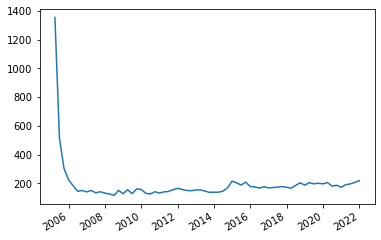

In [167]:
# plot count of significant t stats postive and negative by date
sig["date"].value_counts().plot()

In [170]:
# avg count of significant t stats per date
sig["date"].value_counts().median()

167.0

In [ ]:
# load pickle file
with open('beta_dict_final.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    beta_dict = pickle.load(f)

In [114]:
beta_df = pd.DataFrame.from_dict(beta_dict, orient="index")
beta_df = beta_df.reset_index()
# beta_df.columns = ["date", "gvkey", "beta", "t-stat"]
# beta_df["date"] = pd.to_datetime(beta_df["date"])
# beta_df["gvkey"] = beta_df["gvkey"].astype(int)

In [115]:
beta_df

,level_0,level_1,const,Mkt-RF,SMB,HML,RMW,CMA,UMD,CPI Diff
0,2004-12-31,1003,-0.138276,0.010059,0.026984,-0.061919,0.05857,-0.023065,-0.0118,0.047869


In [ ]:
# create results dataframe
results = pd.DataFrame(columns=["t_stat","mean", "std", "sharpe"])
t_stats = [j/100 for j in range(100, 525, 25)]

for t in t_stats:
    sig_stocks = beta_df[(beta_df["t-stat"] > t) | (beta_df["t-stat"] < -t)]
    # for each month get the count of stocks that are significant groupby date and count
    sig_stocks_count = sig_stocks.groupby("date").count().reset_index()
    # plot the count of significant stocks using plotly
    
    #merge sig_stocs with cpi and shift dates forward 1
    sig_stocks = sig_stocks.merge(cpi, how="left", on="date")
    sig_stocks["shifted_date"] = sig_stocks["date"] + MonthEnd(1)
    # sig_stocks = sig_stocks.drop("date", axis=1)
    sig_stocks
    #shift diff column back 1
    sig_stocks["pred_diff"] = sig_stocks.groupby("gvkey")["diff"].shift(-1)
    #shift diff of diff column back 1
    sig_stocks["pred_diff of diff"] = sig_stocks.groupby("gvkey")["diff_of_diff"].shift(-1)
    sig_stocks
    #Given a month, return the long and short stocks for next period
    def long_short(sig_stocks,date):
        sig_stocks= sig_stocks[sig_stocks["date"]==date]
        #get direction of month
        direction=sig_stocks["pred_diff"].mean()
        #get only ones that are significant
        if direction < 0:
            long_stocks=sig_stocks[sig_stocks["beta"]<0]
            short_stocks=sig_stocks[sig_stocks["beta"]>0]
        else:
            long_stocks=sig_stocks[sig_stocks["beta"]>0]
            short_stocks=sig_stocks[sig_stocks["beta"]<0]
        return long_stocks,short_stocks
        #split into long and short
    #loop through dates and get long and short stocks
    #make dictionary of long and short stocks
    long_dict={}
    short_dict={}
    for date in sig_stocks["date"].unique():
        long_stocks,short_stocks=long_short(sig_stocks,date)
        long_dict[date]=list(long_stocks.gvkey)
        short_dict[date]=list(short_stocks.gvkey)


    sig_stocks = sig_stocks.merge(stocks, how="left", left_on=["date", "gvkey"], right_on=["datadate", "gvkey"])
    #for each date get the return of each stock in the next month
    diff_dict={}
    for date in sig_stocks["date"].unique():
        #get the next month
        #if there is no next month, skip
        if date not in long_dict.keys():
            continue
        next_month=date+MonthEnd(1)
        #get the stocks that are long and short
        long_stocks=long_dict[date]
        short_stocks=short_dict[date]
        #get the returns of the stocks
        long_returns=stocks[(stocks["datadate"]==next_month) & (stocks["gvkey"].isin(long_stocks))]["trt1m"]
        short_returns=stocks[(stocks["datadate"]==next_month) & (stocks["gvkey"].isin(short_stocks))]["trt1m"]
        #get the mean of the returns
        long_mean=long_returns.mean()
        short_mean=short_returns.mean()
        #get the difference
        diff=long_mean-short_mean
        #create a dictionary of dates and differences
        diff_dict[date]=diff
        # #get the t-stat
        # t_stat=diff/np.sqrt((long_returns.var()/len(long_returns))+(short_returns.var()/len(short_returns)))
        # #get the p-value
        # p_value=1-stats.t.cdf(t_stat,len(long_returns)+len(short_returns)-2)
        # print("Date: ",date)
        # print("Long Mean: ",long_mean)
        # print("Short Mean: ",short_mean)
        # print("Difference: ",diff)
        # print("t-stat: ",t_stat)
        # print("p-value: ",p_value)
        # print("")
    #drop keys with nan values
    diff_dict={k: v for k, v in diff_dict.items() if not np.isnan(v)}
    #sort by date
    diff_dict=OrderedDict(sorted(diff_dict.items()))
    #convert to dataframe
    diff_df=pd.DataFrame.from_dict(diff_dict,orient="index")
    diff_df.columns=["diff"]
    diff_df
    diff_df["diff"].mean()
    ff_factors = get_factors()
    excess_returns = diff_df["diff"] - ff_factors.set_index("date")["RF"]
    excess_returns = excess_returns.dropna()
    # calculate sharpe ratio
    sharpe_ratio = excess_returns.mean() / excess_returns.std()
    excess_returns.mean()
    excess_returns.std()
    sharpe_ratio

    # add to new row
    results.loc[len(results)] = [t, excess_returns.mean(), excess_returns.std(), sharpe_ratio]


In [ ]:
results

,t_stat,mean,std,sharpe
0,1.00,-0.541703,4.136965,-0.130942
1,1.25,-0.545083,4.892785,-0.111406
2,1.50,-0.449041,5.785440,-0.077616
3,1.75,-0.680365,6.617465,-0.102813
4,2.00,-0.297868,8.033366,-0.037079
5,2.25,-0.084090,9.445890,-0.008902
6,2.50,-0.022394,11.128876,-0.002012
7,2.75,0.014696,14.325818,0.001026
8,3.00,0.984147,19.155775,0.051376
9,3.25,0.889586,17.186555,0.051761


In [ ]:
results["t_stat"] = t_stats

In [ ]:
results.drop("date", axis=1, inplace=True)

KeyError: "['date'] not found in axis"

In [ ]:
results = results[["t_stat", "sharpe", "mean", "std"]]

In [ ]:
# plot the results, sharpe, mean, std
fig = go.Figure()
#fig.add_trace(go.Scatter(x=results["t_stat"], y=results["sharpe"], mode="lines+markers", name="Sharpe Ratio"))
fig.add_trace(go.Scatter(x=results["t_stat"], y=results["mean"], mode="lines+markers", name="Mean"))
fig.add_trace(go.Scatter(x=results["t_stat"], y=results["std"], mode="lines+markers", name="Std"))

fig.update_layout(title="Results", xaxis_title="t-stat", yaxis_title="Value")

fig.show()


In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=results["t_stat"], y=results["sharpe"], mode="lines+markers", name="Sharpe Ratio"))
# add title
fig.update_layout(title="Sharpe Ratio", xaxis_title="t-stat", yaxis_title="Sharpe Ratio")
fig.show()

In [ ]:
round(results[["t_stat", "sharpe", "mean", "std"]], 3)

,t_stat,sharpe,mean,std
0,1.00,-0.131,-0.542,4.137
1,1.25,-0.111,-0.545,4.893
2,1.50,-0.078,-0.449,5.785
3,1.75,-0.103,-0.680,6.617
4,2.00,-0.037,-0.298,8.033
5,2.25,-0.009,-0.084,9.446
6,2.50,-0.002,-0.022,11.129
7,2.75,0.001,0.015,14.326
8,3.00,0.051,0.984,19.156
9,3.25,0.052,0.890,17.187


In [ ]:
sig_stocks = beta_df[(beta_df["t-stat"] > 4) | (beta_df["t-stat"] < -4)]

In [ ]:
# for each month get the count of stocks that are significant groupby date and count
sig_stocks_count = sig_stocks.groupby("date").count().reset_index()

In [ ]:
# plot the count of significant stocks using plotly
fig = px.line(sig_stocks_count, x="date", y="gvkey")
fig.show()

In [ ]:
#merge sig_stocs with cpi and shift dates forward 1
sig_stocks = sig_stocks.merge(cpi, how="left", on="date")
sig_stocks["shifted_date"] = sig_stocks["date"] + MonthEnd(1)
# sig_stocks = sig_stocks.drop("date", axis=1)
sig_stocks

,date,gvkey,beta,t-stat,CPI,diff,diff_of_diff,shifted_date
0,2008-11-30,1166,9.128890,4.114896,-0.02223,-1.12215,1.50899,2008-12-31
1,2008-12-31,1166,9.123891,4.147361,-0.11359,-0.09136,1.03079,2009-01-31
2,2009-01-31,1166,8.997934,4.040090,0.00846,0.12205,0.21341,2009-02-28
3,2009-02-28,1166,9.069703,4.117109,-0.44648,-0.45494,-0.57699,2009-03-31
4,2008-10-31,1186,11.252240,4.670806,1.09992,-2.63114,-1.40888,2008-11-30
...,...,...,...,...,...,...,...,...
21391,2019-08-31,287622,52.698782,5.858985,1.71662,-0.03016,0.00282,2019-09-30
21392,2019-09-30,287622,58.460261,4.374261,1.76918,0.05256,0.08272,2019-10-31
21393,2016-03-31,318434,26.428691,5.390246,1.17263,0.28101,0.23667,2016-04-30
21394,2016-04-30,318434,23.551366,4.167943,1.07848,-0.09415,-0.37516,2016-05-31


In [ ]:
#shift diff column back 1
sig_stocks["pred_diff"] = sig_stocks.groupby("gvkey")["diff"].shift(-1)
#shift diff of diff column back 1
sig_stocks["pred_diff of diff"] = sig_stocks.groupby("gvkey")["diff_of_diff"].shift(-1)
sig_stocks

,date,gvkey,beta,t-stat,CPI,diff,diff_of_diff,shifted_date,pred_diff,pred_diff of diff
0,2008-11-30,1166,9.128890,4.114896,-0.02223,-1.12215,1.50899,2008-12-31,-0.09136,1.03079
1,2008-12-31,1166,9.123891,4.147361,-0.11359,-0.09136,1.03079,2009-01-31,0.12205,0.21341
2,2009-01-31,1166,8.997934,4.040090,0.00846,0.12205,0.21341,2009-02-28,-0.45494,-0.57699
3,2009-02-28,1166,9.069703,4.117109,-0.44648,-0.45494,-0.57699,2009-03-31,NaN,NaN
4,2008-10-31,1186,11.252240,4.670806,1.09992,-2.63114,-1.40888,2008-11-30,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
21391,2019-08-31,287622,52.698782,5.858985,1.71662,-0.03016,0.00282,2019-09-30,0.05256,0.08272
21392,2019-09-30,287622,58.460261,4.374261,1.76918,0.05256,0.08272,2019-10-31,NaN,NaN
21393,2016-03-31,318434,26.428691,5.390246,1.17263,0.28101,0.23667,2016-04-30,-0.09415,-0.37516
21394,2016-04-30,318434,23.551366,4.167943,1.07848,-0.09415,-0.37516,2016-05-31,-0.21093,-0.21174


In [ ]:
#Given a month, return the long and short stocks for next period
def long_short(sig_stocks,date):
    sig_stocks= sig_stocks[sig_stocks["date"]==date]
    #get direction of month
    direction=sig_stocks["pred_diff"].mean()
    #get only ones that are significant
    if direction < 0:
        long_stocks=sig_stocks[sig_stocks["beta"]<0]
        short_stocks=sig_stocks[sig_stocks["beta"]>0]
    else:
        long_stocks=sig_stocks[sig_stocks["beta"]>0]
        short_stocks=sig_stocks[sig_stocks["beta"]<0]
    return long_stocks,short_stocks
    #split into long and short

In [ ]:
#loop through dates and get long and short stocks
#make dictionary of long and short stocks
long_dict={}
short_dict={}
for date in sig_stocks["date"].unique():
    long_stocks,short_stocks=long_short(sig_stocks,date)
    long_dict[date]=list(long_stocks.gvkey)
    short_dict[date]=list(short_stocks.gvkey)


In [ ]:
'''
index vs gvkey
sig stocks only and not entire stock market...unknown if significant last year
sig_stocks and sig_t should be the same

'''

'\nindex vs gvkey\nsig stocks only and not entire stock market...unknown if significant last year\nsig_stocks and sig_t should be the same\n\n'

In [ ]:
sig_stocks = sig_stocks.merge(stocks, how="left", left_on=["date", "gvkey"], right_on=["datadate", "gvkey"])

In [ ]:
#for each date get the return of each stock in the next month
diff_dict={}
for date in sig_stocks["date"].unique():
    #get the next month
    #if there is no next month, skip
    if date not in long_dict.keys():
        continue
    next_month=date+MonthEnd(1)
    #get the stocks that are long and short
    long_stocks=long_dict[date]
    short_stocks=short_dict[date]
    #get the returns of the stocks
    long_returns=stocks[(stocks["datadate"]==next_month) & (stocks["gvkey"].isin(long_stocks))]["trt1m"]
    short_returns=stocks[(stocks["datadate"]==next_month) & (stocks["gvkey"].isin(short_stocks))]["trt1m"]
    #get the mean of the returns
    long_mean=long_returns.mean()
    short_mean=short_returns.mean()
    #get the difference
    diff=long_mean-short_mean
    #create a dictionary of dates and differences
    diff_dict[date]=diff
    # #get the t-stat
    # t_stat=diff/np.sqrt((long_returns.var()/len(long_returns))+(short_returns.var()/len(short_returns)))
    # #get the p-value
    # p_value=1-stats.t.cdf(t_stat,len(long_returns)+len(short_returns)-2)
    # print("Date: ",date)
    # print("Long Mean: ",long_mean)
    # print("Short Mean: ",short_mean)
    # print("Difference: ",diff)
    # print("t-stat: ",t_stat)
    # print("p-value: ",p_value)
    # print("")

In [ ]:
#drop keys with nan values
diff_dict={k: v for k, v in diff_dict.items() if not np.isnan(v)}
#sort by date
diff_dict=OrderedDict(sorted(diff_dict.items()))
#convert to dataframe
diff_df=pd.DataFrame.from_dict(diff_dict,orient="index")
diff_df.columns=["diff"]
diff_df

,diff
2004-11-30,0.705597
2004-12-31,11.717035
2005-01-31,4.924956
2005-02-28,50.623050
2005-03-31,-0.628743
...,...
2019-07-31,-3.611662
2019-08-31,10.878370
2019-09-30,22.243458
2019-10-31,0.140807


In [ ]:
diff_df["diff"].mean()

1.558134324145908

In [ ]:
ff_factors = get_factors()

In [ ]:
excess_returns = diff_df["diff"] - ff_factors.set_index("date")["RF"]

In [ ]:
excess_returns = excess_returns.dropna()

In [ ]:
# calculate sharpe ratio
sharpe_ratio = excess_returns.mean() / excess_returns.std()

In [ ]:
excess_returns.mean()

1.4541119777771934

In [ ]:
excess_returns.std()

26.49126531597928

In [ ]:
sharpe_ratio

0.05489024251703398

In [ ]:
#Histogram of differences
fig = px.histogram(diff_df, x="diff", nbins=100, title="Difference Distribution")
fig.show()


,date,gvkey,beta,t-stat,CPI,diff,diff_of_diff,shifted_date
0,2005-06-30,1009,-80.726283,-2.218897,3.06716,0.52613,0.85439,2005-07-31
1,2005-08-31,1009,-67.091382,-2.585226,4.74183,1.09490,0.51513,2005-09-30
2,2005-09-30,1009,-69.886995,-2.946334,4.35010,-0.39173,-1.48663,2005-10-31
3,2005-11-30,1009,-68.970612,-2.773012,3.33855,0.00000,1.01155,2005-12-31
4,2006-02-28,1009,-53.971757,-2.121254,3.41792,-0.22033,0.16021,2006-03-31
...,...,...,...,...,...,...,...,...
369622,2017-06-30,351371,-43.139448,-2.299032,1.72511,0.08454,0.30031,2017-07-31
369623,2017-07-31,351371,-43.319004,-2.434378,1.92812,0.20301,0.11847,2017-08-31
369624,2017-08-31,351371,-42.764813,-2.535639,2.18057,0.25245,0.04944,2017-09-30
369625,2018-10-31,351371,-34.040645,-2.168523,2.14733,-0.34470,-0.50467,2018-11-30


,date,gvkey,beta,t-stat,CPI,diff,diff_of_diff,shifted_date,pred_diff,pred_diff of diff
0,2005-06-30,1009,-80.726283,-2.218897,3.06716,0.52613,0.85439,2005-07-31,1.09490,0.51513
1,2005-08-31,1009,-67.091382,-2.585226,4.74183,1.09490,0.51513,2005-09-30,-0.39173,-1.48663
2,2005-09-30,1009,-69.886995,-2.946334,4.35010,-0.39173,-1.48663,2005-10-31,0.00000,1.01155
3,2005-11-30,1009,-68.970612,-2.773012,3.33855,0.00000,1.01155,2005-12-31,-0.22033,0.16021
4,2006-02-28,1009,-53.971757,-2.121254,3.41792,-0.22033,0.16021,2006-03-31,0.19592,0.41625
...,...,...,...,...,...,...,...,...,...,...
369622,2017-06-30,351371,-43.139448,-2.299032,1.72511,0.08454,0.30031,2017-07-31,0.20301,0.11847
369623,2017-07-31,351371,-43.319004,-2.434378,1.92812,0.20301,0.11847,2017-08-31,0.25245,0.04944
369624,2017-08-31,351371,-42.764813,-2.535639,2.18057,0.25245,0.04944,2017-09-30,-0.34470,-0.50467
369625,2018-10-31,351371,-34.040645,-2.168523,2.14733,-0.34470,-0.50467,2018-11-30,-0.14495,0.19975


In [ ]:
sig_stocks = sig_stocks.sort_values("date")

# port const

In [ ]:
#Given a month, return the long and short stocks for next period
def long_short(sig_stocks,date):
    sig_stocks= sig_stocks[sig_stocks["date"]==date]
    
    #get direction of month...all the same
    direction=sig_stocks["pred_diff"].mean()

    #get only ones that are significant
    if direction < 0:
        long_stocks=sig_stocks[sig_stocks["beta"]<0]
        # long_stocks["bin"]=pd.qcut(long_stocks["beta"], 4, labels=["L", "1", "2", "H"])

        short_stocks=sig_stocks[sig_stocks["beta"]>0]
        #short_stocks["bin"]=pd.qcut(short_stocks["beta"], 4, labels=["L", "1", "2", "H"])

        # long_stocks = long_stocks[long_stocks["bin"] == "L"]
        #short_stocks = short_stocks[short_stocks["bin"] == "H"]

    else:
        long_stocks=sig_stocks[sig_stocks["beta"]>0]
        #long_stocks["bin"]=pd.qcut(long_stocks["beta"], 4, labels=["L", "1", "2", "H"])

        short_stocks=sig_stocks[sig_stocks["beta"]<0]
        # short_stocks["bin"]=pd.qcut(short_stocks["beta"], 4, labels=["L", "1", "2", "H"])

        #long_stocks = long_stocks[long_stocks["bin"] == "H"]
        # short_stocks = short_stocks[short_stocks["bin"] == "L"]
        
    return long_stocks,short_stocks
    #split into long and short

In [ ]:
#loop through dates and get long and short stocks
#make dictionary of long and short stocks
long_dict={}
short_dict={}

long_short_dict={}

for date in sig_stocks["date"].unique():
    long_stocks,short_stocks=long_short(sig_stocks,date)
    long_short_dict[date] = {}
    long_short_dict[date]["long"]=list(long_stocks.gvkey)
    long_short_dict[date]["short"]=list(short_stocks.gvkey)

    long_dict[date] = list(long_stocks.gvkey)
    short_dict[date] = list(short_stocks.gvkey)



In [ ]:
# combine 
portfolio = pd.DataFrame.from_dict(long_short_dict).T
portfolio.reset_index(inplace=True)
portfolio.columns = ["date", "long", "short"]

In [ ]:
portfolio

,date,long,short
0,2004-11-30,"[8, 13, 14, 16, 37, 43, 44, 47, 51, 53, 57, 66...","[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 15, 17..."
1,2004-12-31,"[1285, 1286, 1289, 1290, 1292, 1293, 1294, 129...","[1287, 1288, 1291, 1296, 1308, 1309, 1310, 131..."
2,2005-01-31,"[2327, 2328, 2329, 2330, 2332, 2334, 2338, 233...","[2331, 2333, 2335, 2336, 2337, 2340, 2341, 234..."
3,2005-02-28,"[3273, 3274, 3278, 3279, 3281, 3282, 3284, 328...","[3275, 3276, 3277, 3280, 3283, 3285, 3286, 328..."
4,2005-03-31,"[4220, 4222, 4223, 4224, 4225, 4227, 4228, 422...","[4218, 4219, 4221, 4226, 4230, 4231, 4232, 423..."
...,...,...,...
177,2019-08-31,"[423710, 423711, 423712, 423713, 423715, 42371...","[423714, 423761, 423770, 423779, 423791, 42380..."
178,2019-09-30,"[426602, 426603, 426604, 426605, 426606, 42660...","[426692, 426693, 426948, 426979, 426987, 42717..."
179,2019-10-31,"[429489, 429490, 429491, 429492, 429493, 42949...","[429539, 429597, 429680, 429714, 429823, 42984..."
180,2019-11-30,"[432330, 432331, 432332, 432333, 432334, 43233...","[432501, 432520, 432521, 432581, 432670, 43269..."


In [ ]:
# get size of long from each row
long_size = []
short_size = []
for i in range(len(portfolio)): 
    long_size.append(len(portfolio["long"][i]))
    short_size.append(len(portfolio["short"][i]))

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=portfolio["date"], y=long_size, name="long"))
fig.add_trace(go.Scatter(x=portfolio["date"], y=short_size, name="short"))
fig.update_layout(title="Size of Long and Short", xaxis_title="Date", yaxis_title="Size of Long and Short")

# plot cpi
fig.add_trace(go.Scatter(x=cpi["date"], y=cpi["CPI"], name="CPI", yaxis="y2"))
fig.update_layout(yaxis2=dict(overlaying="y", side="right", title="CPI"))

fig.show()

In [ ]:
sig_stocks = sig_stocks.merge(stocks[["datadate", "gvkey", "trt1m"]], how="left", left_on=["gvkey", "date"], right_on=["gvkey", "datadate"])

In [ ]:
portfolio

,date,long,short
0,2004-11-30,"[21519, 28111, 28109, 23218, 112622, 19159, 85...","[124438, 151908, 143664, 112544, 124320, 12435..."
1,2004-12-31,"[12550, 121662, 105478, 65809, 65809, 105570, ...","[24943, 24943, 205874, 3138, 29944, 10013, 285..."
2,2005-01-31,"[16454, 152808, 108172, 62521, 155032, 62206, ...","[30598, 205942, 106903, 26065, 110386, 205874,..."
3,2005-02-28,"[142380, 143625, 148240, 21311, 140190, 2204, ...","[63896, 63896, 62592, 64017, 21320, 62597, 157..."
4,2005-03-31,"[5330, 108365, 157235, 17286, 17197, 11708, 31...","[160926, 63826, 25364, 107541, 105478, 105488,..."
...,...,...,...
177,2019-08-31,"[186126, 183278, 183278, 160341, 285660, 19627...","[61090, 147564, 171114, 147891, 31668, 194855,..."
178,2019-09-30,"[184113, 19359, 19359, 175474, 175474, 107616,...","[186173, 186173, 177166, 184142, 180390, 31453..."
179,2019-10-31,"[30571, 32698, 180874, 180874, 177487, 18874, ...","[31848, 147891, 276613, 66597, 16705, 26045, 1..."
180,2019-11-30,"[111667, 32870, 5284, 5284, 31628, 26881, 2688...","[66042, 184747, 184747, 33858, 33852, 21765, 6..."


In [ ]:
returns_dict={}
for date in portfolio["date"]:
    next_month=date+MonthEnd(1)
    # get all stocks we want to long
    long_stocks = portfolio[(portfolio["date"] == date)]["long"].values[0]
    short_stocks = portfolio[(portfolio["date"] == date)]["short"].values[0]
    long_returns=stocks[(stocks["datadate"]==next_month) & (stocks["gvkey"].isin(long_stocks))]["trt1m"]
    short_returns=stocks[(stocks["datadate"]==next_month) & (stocks["gvkey"].isin(short_stocks))]["trt1m"]

    long_mean=long_returns.mean()
    short_mean=short_returns.mean()

    long_short_return=long_mean-short_mean

    returns_dict[date]=long_short_return

In [ ]:
#for each date get the return of each stock in the next month
returns_dict={}
for date in sig_stocks["date"].sort_values().unique():
    #get the next month
    #if there is no next month, skip
    # if date not in long_dict.keys():
    #     continue
    next_month=date+MonthEnd(1)
    #get the stocks that are long and short
    long_stocks=long_dict[date]
    short_stocks=short_dict[date]
    #get the returns of the stocks
    long_returns=stocks[(stocks["datadate"]==next_month) & (stocks["gvkey"].isin(long_stocks))]["trt1m"]
    short_returns=stocks[(stocks["datadate"]==next_month) & (stocks["gvkey"].isin(short_stocks))]["trt1m"]
    # break
    #get the mean of the returns
    long_mean=long_returns.mean()
    short_mean=short_returns.mean()
    #get the difference
    long_short_return=long_mean-short_mean
    #create a dictionary of dates and differences
    returns_dict[date]=long_short_return
    # #get the t-stat
    # t_stat=diff/np.sqrt((long_returns.var()/len(long_returns))+(short_returns.var()/len(short_returns)))
    # #get the p-value
    # p_value=1-stats.t.cdf(t_stat,len(long_returns)+len(short_returns)-2)
    # print("Date: ",date)
    # print("Long Mean: ",long_mean)
    # print("Short Mean: ",short_mean)
    # print("Difference: ",diff)
    # print("t-stat: ",t_stat)
    # print("p-value: ",p_value)
    # print("")

In [ ]:
#drop keys with nan values
returns_dict={k: v for k, v in returns_dict.items() if not np.isnan(v)}
#sort by date
returns_dict=OrderedDict(sorted(returns_dict.items()))
#convert to dataframe
returns_dict=pd.DataFrame.from_dict(returns_dict,orient="index")
returns_dict.columns=["return"]
returns_dict

,return
2004-11-30,3.773637
2004-12-31,1.891985
2005-01-31,-3.497916
2005-02-28,-3.386312
2005-03-31,1.054663
...,...
2019-07-31,9.748178
2019-08-31,-12.306143
2019-09-30,-14.330279
2019-10-31,4.249741


In [ ]:
# plot months
fig = px.line(returns_dict, x=returns_dict.index, y="return")
fig.show()


In [ ]:
returns_dict["return"].mean()

-0.19147243037882578

In [ ]:
#Histogram of long-short returns
fig = px.histogram(returns_dict, x="return", nbins=100, title="Long Short Distribution")
fig.show()
